<a href="https://colab.research.google.com/github/mrdbourke/pytorch-deep-learning/blob/main/extras/exercises/06_pytorch_transfer_learning_exercises.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 06. PyTorch Transfer Learning Exercises

Welcome to the 06. PyTorch Transfer Learning exercise template notebook.

There are several questions in this notebook and it's your goal to answer them by writing Python and PyTorch code.

> **Note:** There may be more than one solution to each of the exercises, don't worry too much about the *exact* right answer. Try to write some code that works first and then improve it if you can.

## Resources and solutions

* These exercises/solutions are based on [section 06. PyTorch Transfer Learning](https://www.learnpytorch.io/06_pytorch_transfer_learning/) of the Learn PyTorch for Deep Learning course by Zero to Mastery.

**Solutions:** 

Try to complete the code below *before* looking at these.

* See a live [walkthrough of the solutions (errors and all) on YouTube](https://youtu.be/ueLolShyFqs).
* See an example [solutions notebook for these exercises on GitHub](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/extras/solutions/06_pytorch_transfer_learning_exercise_solutions.ipynb).

## 1. Make predictions on the entire test dataset and plot a confusion matrix for the results of our model compared to the truth labels. 
* **Note:** You will need to get the dataset and the trained model/retrain the model from notebook 06 to perform predictions.
* Check out [03. PyTorch Computer Vision section 10](https://www.learnpytorch.io/03_pytorch_computer_vision/#10-making-a-confusion-matrix-for-further-prediction-evaluation) for ideas.

In [1]:
# Import required libraries/code
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt

from torch import nn
from torchvision import transforms, datasets

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine

/home/octo/code/ENTER/envs/cs285/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

### Get data 

In [3]:
import os
import requests
import zipfile

from pathlib import Path

# Setup path to data folder
data_path = Path("../../data/")
image_path = data_path / "pizza_steak_sushi"

# If the image folder doesn't exist, download it and prepare it... 
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)
    
    # Download pizza, steak, sushi data
    with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
        print("Downloading pizza, steak, sushi data...")
        f.write(request.content)

    # Unzip pizza, steak, sushi data
    with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
        print("Unzipping pizza, steak, sushi data...") 
        zip_ref.extractall(image_path)

    # Remove .zip file
    os.remove(data_path / "pizza_steak_sushi.zip")

# Setup Dirs
train_dir = image_path / "train"
test_dir = image_path / "test"

../../data/pizza_steak_sushi directory exists.


### Prepare data

In [5]:
# Create a transforms pipeline
simple_transform = transforms.Compose([
    transforms.Resize((224, 224)), # 1. Reshape all images to 224x224 (though some models may require different sizes)
    transforms.ToTensor(), # 2. Turn image values to between 0 & 1 
    transforms.Normalize(mean=[0.485, 0.456, 0.406], # 3. A mean of [0.485, 0.456, 0.406] (across each colour channel)
                         std=[0.229, 0.224, 0.225]) # 4. A standard deviation of [0.229, 0.224, 0.225] (across each colour channel),
])

In [6]:
# Create training and testing DataLoader's as well as get a list of class names
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                               test_dir=test_dir,
                                                                               transform=simple_transform, # resize, convert images to between 0 & 1 and normalize them
                                                                               batch_size=32) # set mini-batch size to 32

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x73fac5c44fd0>,
 ['pizza', 'steak', 'sushi'])

### Get and prepare a pretrained model

In [7]:
# Setup the model with pretrained weights and send it to the target device 
model_0 = torchvision.models.efficientnet_b0(pretrained=True).to(device)
#model_0 # uncomment to output (it's very long)

/home/octo/code/ENTER/envs/cs285/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/octo/code/ENTER/envs/cs285/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-3dd342df.pth" to /home/octo/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-3dd342df.pth
100%|██████████| 20.5M/20.5M [01:21<00:00, 263kB/s] 


In [8]:
# Freeze all base layers in the "features" section of the model (the feature extractor) by setting requires_grad=False
for param in model_0.features.parameters():
    param.requires_grad = False

In [9]:
# Set the manual seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Get the length of class_names (one output unit for each class)
output_shape = len(class_names)

# Recreate the classifier layer and seed it to the target device
model_0.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True), 
    torch.nn.Linear(in_features=1280, 
                    out_features=output_shape, # same number of output units as our number of classes
                    bias=True)).to(device)

### Train model

In [10]:
# Define loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_0.parameters(), lr=0.001)

In [11]:
# Set the random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Start the timer
from timeit import default_timer as timer 
start_time = timer()

# Setup training and save the results
model_0_results = engine.train(model=model_0,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=5,
                       device=device)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

 20%|██        | 1/5 [00:03<00:14,  3.70s/it]

Epoch: 1 | train_loss: 1.0895 | train_acc: 0.4414 | test_loss: 0.9202 | test_acc: 0.5085


 40%|████      | 2/5 [00:05<00:06,  2.29s/it]

Epoch: 2 | train_loss: 0.8682 | train_acc: 0.7734 | test_loss: 0.8020 | test_acc: 0.7434


 60%|██████    | 3/5 [00:06<00:03,  1.85s/it]

Epoch: 3 | train_loss: 0.7770 | train_acc: 0.7812 | test_loss: 0.7398 | test_acc: 0.7737


 80%|████████  | 4/5 [00:07<00:01,  1.66s/it]

Epoch: 4 | train_loss: 0.7248 | train_acc: 0.7422 | test_loss: 0.6471 | test_acc: 0.8864


100%|██████████| 5/5 [00:09<00:00,  1.81s/it]

Epoch: 5 | train_loss: 0.6444 | train_acc: 0.7812 | test_loss: 0.6243 | test_acc: 0.8968
[INFO] Total training time: 9.060 seconds


### Make predictions on the entire test dataset with the model

In [22]:
data_path, image_path,test_dir

(PosixPath('../../data'),
 PosixPath('../../data/pizza_steak_sushi'),
 PosixPath('../../data/pizza_steak_sushi/test'))

75


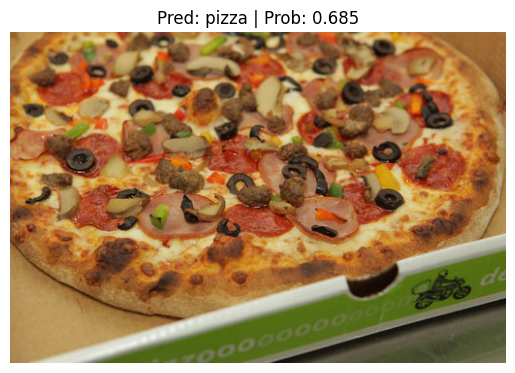

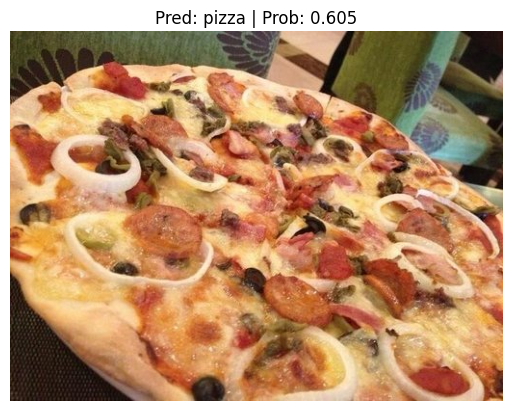

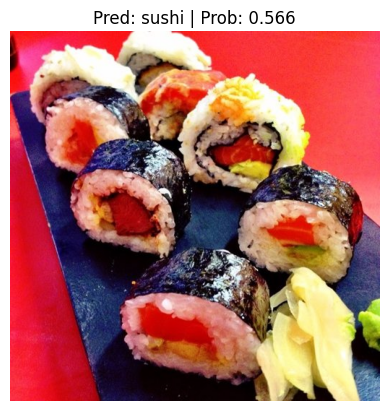

In [ ]:
# Random test dataset prediction and plot
import random
from going_modular.going_modular.predictions import pred_and_plot_image

num_image_to_plot = 3
test_image_path_list = list(Path(test_dir).glob("*/*.jpg"))
print(len(test_image_path_list))

test_image_sample = random.sample(test_image_path_list, k=3)

for test_img_path in test_image_sample:
    pred_and_plot_image(model=model_0,
                        class_names=class_names,
                        image_path=test_img_path,
                        transform=simple_transform,
                        device=device)



In [36]:
from tqdm.auto import tqdm

# Make predictions on the entire test dataset
test_pred = []

## Set model to eval() mode
model_0.eval()

with torch.inference_mode():
    for X,y in test_dataloader:
        # Move data to device
        X, y = X.to(device), y.to(device)

        # Make predictions and save label
        y_logits_test = model_0(X)
        y_labels_test = torch.argmax(torch.softmax(y_logits_test, dim=1), dim=1)
        test_pred.append(y_labels_test)

test_pred = torch.cat(test_pred).cpu()
test_pred

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 2, 1, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0,
        2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2,
        2, 2, 2])

### Make a confusion matrix with the test preds and the truth labels

Need the following libraries to make a confusion matrix:
* torchmetrics - https://torchmetrics.readthedocs.io/en/stable/
* mlxtend - http://rasbt.github.io/mlxtend/

In [29]:
# See if torchmetrics exists, if not, install it
try:
    import torchmetrics, mlxtend
    print(f"mlxtend version: {mlxtend.__version__}")
    assert int(mlxtend.__version__.split(".")[1]) >= 19, "mlxtend verison should be 0.19.0 or higher"
except:
    !pip install -q torchmetrics -U mlxtend # <- Note: If you're using Google Colab, this may require restarting the runtime
    import torchmetrics, mlxtend
    print(f"mlxtend version: {mlxtend.__version__}")

mlxtend version: 0.23.3


In [37]:
# Import mlxtend upgraded version
import mlxtend 
print(mlxtend.__version__)
assert int(mlxtend.__version__.split(".")[1]) >= 19 # should be version 0.19.0 or higher

0.23.3


In [38]:
test_truth = torch.cat([y for _,y in test_dataloader])
test_truth

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2])

(<Figure size 1000x700 with 1 Axes>,
 <AxesSubplot:xlabel='predicted label', ylabel='true label'>)

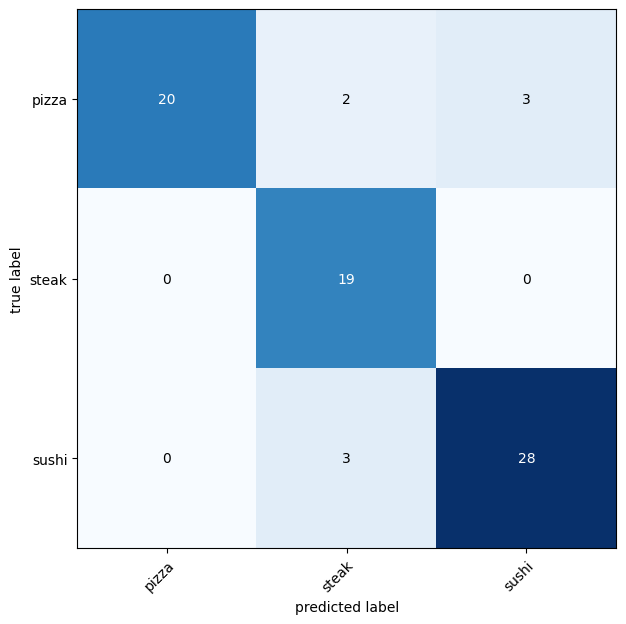

In [44]:
# DONE: Make a confusion matrix
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

confmat = ConfusionMatrix(task="multiclass",
                          num_classes=len(class_names))
confmat_tensor = confmat(preds=test_pred,
                         target=test_truth)

plot_confusion_matrix(conf_mat=confmat_tensor.numpy(),
                      class_names=class_names,
                      figsize=(10, 7))

## 2. Get the "most wrong" of the predictions on the test dataset and plot the 5 "most wrong" images. You can do this by:
* Predicting across all of the test dataset, storing the labels and predicted probabilities.
* Sort the predictions by *wrong prediction* and then *descending predicted probabilities*, this will give you the wrong predictions with the *highest* prediction probabilities, in other words, the "most wrong".
* Plot the top 5 "most wrong" images, why do you think the model got these wrong?

You'll want to:
* Create a DataFrame with sample, label, prediction, pred prob
* Sort DataFrame by correct (does label == prediction)
* Sort DataFrame by pred prob (descending)
* Plot the top 5 "most wrong" image predictions

In [50]:
test_dir

PosixPath('../../data/pizza_steak_sushi/test')

In [65]:
from pathlib import Path
test_data_paths = list(Path(test_dir).glob("*/*.jpg"))

test_data_paths[:5]

[PosixPath('../../data/pizza_steak_sushi/test/steak/1868005.jpg'),
 PosixPath('../../data/pizza_steak_sushi/test/steak/2117351.jpg'),
 PosixPath('../../data/pizza_steak_sushi/test/steak/1285886.jpg'),
 PosixPath('../../data/pizza_steak_sushi/test/steak/354513.jpg'),
 PosixPath('../../data/pizza_steak_sushi/test/steak/296375.jpg')]

In [75]:
from pathlib import Path
test_data_paths = list(Path(test_dir).glob("*/*.jpg"))
# test_labels = [path.parent.stem for path in test_data_paths]

def pred_and_store(model: nn.Module,
                   test_paths,
                   transform,
                   class_names,
                   device):
    test_result = []

    # Model evaluation mode
    model.eval()
    # Pred files in test path
    from PIL import Image

    with torch.inference_mode():
        for path in tqdm(test_paths):
            pred_dict = dict()

            pred_dict["path"] = path
            class_name = path.parent.stem
            pred_dict["true_class"] = class_name

            img = Image.open(path)
            transformed_img = transform(img).unsqueeze(0)

            # Make predtions
            y_logits = model(transformed_img.to(device))
            y_prob = torch.softmax(y_logits, dim=1)
            y_label = torch.argmax(y_prob, dim=1)
            pred_class = class_names[y_label.cpu()]

            pred_dict["pred_prob"] = y_prob.max().cpu().item()
            pred_dict["pred_class"] = pred_class
            pred_dict["correct"] = class_name == pred_class

            test_result.append(pred_dict)

    return test_result

test_pred_result = pred_and_store(model=model_0,
                                  test_paths=test_data_paths,
                                  transform=simple_transform,
                                  class_names=class_names,
                                  device=device)

test_pred_result[:5], len(test_data_paths)

100%|██████████| 75/75 [00:00<00:00, 156.02it/s]


([{'path': PosixPath('../../data/pizza_steak_sushi/test/steak/1868005.jpg'),
   'true_class': 'steak',
   'pred_prob': 0.7606634497642517,
   'pred_class': 'steak',
   'correct': True},
  {'path': PosixPath('../../data/pizza_steak_sushi/test/steak/2117351.jpg'),
   'true_class': 'steak',
   'pred_prob': 0.6921660900115967,
   'pred_class': 'steak',
   'correct': True},
  {'path': PosixPath('../../data/pizza_steak_sushi/test/steak/1285886.jpg'),
   'true_class': 'steak',
   'pred_prob': 0.4597998261451721,
   'pred_class': 'steak',
   'correct': True},
  {'path': PosixPath('../../data/pizza_steak_sushi/test/steak/354513.jpg'),
   'true_class': 'steak',
   'pred_prob': 0.5344505310058594,
   'pred_class': 'steak',
   'correct': True},
  {'path': PosixPath('../../data/pizza_steak_sushi/test/steak/296375.jpg'),
   'true_class': 'steak',
   'pred_prob': 0.8939927220344543,
   'pred_class': 'steak',
   'correct': True}],
 75)

In [76]:
# DONE: Get top 5 wrong predictions and plot
import pandas as pd

test_pred_df = pd.DataFrame(data=test_pred_result)

top_5_most_wrong = test_pred_df.sort_values(by=["correct", "pred_prob"], ascending=[True, False]).head()

top_5_most_wrong

,path,true_class,pred_prob,pred_class,correct
58,../../data/pizza_steak_sushi/test/sushi/684266...,sushi,0.546824,steak,False
55,../../data/pizza_steak_sushi/test/sushi/117225...,sushi,0.449366,steak,False
38,../../data/pizza_steak_sushi/test/pizza/971934...,pizza,0.445324,sushi,False
21,../../data/pizza_steak_sushi/test/pizza/250863...,pizza,0.435192,sushi,False
30,../../data/pizza_steak_sushi/test/pizza/309892...,pizza,0.427036,sushi,False


## 3. Predict on your own image of pizza/steak/sushi - how does the model go? What happens if you predict on an image that isn't pizza/steak/sushi?
* Here you can get an image from a website like http://www.unsplash.com to try it out or you can upload your own.

In [80]:
data_path

PosixPath('../../data')

In [85]:
# DONE: Get an image of pizza/steak/sushi

def user_image_classify(model,
                        data_path,
                        transform,
                        img_name:str) -> None:
    my_image = data_path / img_name

    from PIL import Image
    img = Image.open(my_image)
    transformed_img = simple_transform(img).unsqueeze(0)

    model.eval()
    with torch.inference_mode():
        y_logits = model(transformed_img.to(device))
        y_prob = torch.softmax(y_logits, dim=1)
        y_pred = torch.argmax(y_prob, dim=1)

    print(class_names[y_pred], y_prob)

user_image_classify(model_0, data_path, simple_transform, "my-pizza.jpg")

pizza tensor([[0.5102, 0.2143, 0.2755]], device='cuda:0')


In [86]:
# TODO: Get an image of not pizza/steak/sushi
user_image_classify(model_0, data_path, simple_transform, "dragon.jpg")

sushi tensor([[0.1419, 0.3437, 0.5144]], device='cuda:0')


## 4. Train the model from section 4  in notebook 06 part 3 for longer (10 epochs should do), what happens to the performance?

* See the model in notebook 06 part 3 for reference: https://www.learnpytorch.io/06_pytorch_transfer_learning/#3-getting-a-pretrained-model

In [ ]:
# DONE: Recreate a new model
import torchvision

model_1 = torchvision.models.efficientnet_b0(pretrained=True).to(device)

for param in model_1.features.parameters():
    param.requires_grad = False

/home/octo/code/ENTER/envs/cs285/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/octo/code/ENTER/envs/cs285/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [97]:
from torchinfo import summary
summary(model_1, 
        input_size=(32, 3, 224, 224),
        verbose=0,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        row_settings=["var_names"]
        )

Layer (type (var_name))                                      Input Shape               Output Shape              Param #                   Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]         [32, 1000]                --                        Partial
├─Sequential (features)                                      [32, 3, 224, 224]         [32, 1280, 7, 7]          --                        False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]         [32, 32, 112, 112]        --                        False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]         [32, 32, 112, 112]        (864)                     False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]        [32, 32, 112, 112]        (64)                      False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]        [32, 32, 112, 112]        --         

In [99]:
model_1.classifier = nn.Sequential(
    nn.Dropout(p=0.2),
    nn.Linear(in_features=1280, out_features=len(class_names))
)

summary(model_1, 
        input_size=(32, 3, 224, 224),
        verbose=0,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        row_settings=["var_names"]
        )

Layer (type (var_name))                                      Input Shape               Output Shape              Param #                   Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]         [32, 3]                   --                        Partial
├─Sequential (features)                                      [32, 3, 224, 224]         [32, 1280, 7, 7]          --                        False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]         [32, 32, 112, 112]        --                        False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]         [32, 32, 112, 112]        (864)                     False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]        [32, 32, 112, 112]        (64)                      False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]        [32, 32, 112, 112]        --         

In [ ]:
# DONE: Train the model for 10 epochs
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_1.parameters(), 
                             lr=0.001)

torch.manual_seed(42)
torch.cuda.manual_seed(42)

from timeit import default_timer as timer

start_time = timer()

model_1_results = engine.train(model_1, train_dataloader, test_dataloader, optimizer, loss_fn, epochs=10, device=device)

end_time = timer()

print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

 10%|█         | 1/10 [00:01<00:13,  1.46s/it]

Epoch: 1 | train_loss: 1.0715 | train_acc: 0.4336 | test_loss: 0.8806 | test_acc: 0.6297


 20%|██        | 2/10 [00:02<00:11,  1.46s/it]

Epoch: 2 | train_loss: 0.8535 | train_acc: 0.7070 | test_loss: 0.7950 | test_acc: 0.7850


 30%|███       | 3/10 [00:04<00:10,  1.44s/it]

Epoch: 3 | train_loss: 0.7545 | train_acc: 0.8203 | test_loss: 0.7324 | test_acc: 0.8153


 40%|████      | 4/10 [00:05<00:08,  1.44s/it]

Epoch: 4 | train_loss: 0.7169 | train_acc: 0.7617 | test_loss: 0.6369 | test_acc: 0.8977


 50%|█████     | 5/10 [00:07<00:07,  1.45s/it]

Epoch: 5 | train_loss: 0.6308 | train_acc: 0.8047 | test_loss: 0.6249 | test_acc: 0.8759


 60%|██████    | 6/10 [00:08<00:05,  1.46s/it]

Epoch: 6 | train_loss: 0.5670 | train_acc: 0.8984 | test_loss: 0.5580 | test_acc: 0.9176


 70%|███████   | 7/10 [00:10<00:04,  1.45s/it]

Epoch: 7 | train_loss: 0.5202 | train_acc: 0.9219 | test_loss: 0.5276 | test_acc: 0.9280


 80%|████████  | 8/10 [00:11<00:02,  1.45s/it]

Epoch: 8 | train_loss: 0.5406 | train_acc: 0.8008 | test_loss: 0.5301 | test_acc: 0.8873


 90%|█████████ | 9/10 [00:13<00:01,  1.45s/it]

Epoch: 9 | train_loss: 0.5917 | train_acc: 0.8125 | test_loss: 0.4894 | test_acc: 0.9489


100%|██████████| 10/10 [00:14<00:00,  1.45s/it]

Epoch: 10 | train_loss: 0.4820 | train_acc: 0.8242 | test_loss: 0.4117 | test_acc: 0.8968
[INFO] Total training time: 14.554 seconds


## 5. Train the model from section 4 above with more data, say 20% of the images from Food101 of Pizza, Steak and Sushi images.
* You can find the [20% Pizza, Steak, Sushi dataset](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/data/pizza_steak_sushi_20_percent.zip) on the course GitHub. It was created with the notebook [`extras/04_custom_data_creation.ipynb`](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/extras/04_custom_data_creation.ipynb). 


### Get 20% data

In [107]:
import os
import requests
import zipfile

from pathlib import Path

# Setup path to data folder
data_path = Path("../../data/")
image_path = data_path / "pizza_steak_sushi_20_percent"
image_data_zip_path = "pizza_steak_sushi_20_percent.zip"

# If the image folder doesn't exist, download it and prepare it... 
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)
    
    # Download pizza, steak, sushi data
    with open(data_path / image_data_zip_path, "wb") as f:
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip")
        print("Downloading pizza, steak, sushi data...")
        f.write(request.content)

    # Unzip pizza, steak, sushi data
    with zipfile.ZipFile(data_path / image_data_zip_path, "r") as zip_ref:
        print("Unzipping pizza, steak, sushi 20% data...") 
        zip_ref.extractall(image_path)

    # Remove .zip file
    os.remove(data_path / image_data_zip_path)

# Setup Dirs
train_dir_20_percent = image_path / "train"
test_dir_20_percent = image_path / "test"

train_dir_20_percent, test_dir_20_percent

../../data/pizza_steak_sushi_20_percent directory exists.


(PosixPath('../../data/pizza_steak_sushi_20_percent/train'),
 PosixPath('../../data/pizza_steak_sushi_20_percent/test'))

### Create DataLoaders

In [108]:
# Create a transforms pipeline
simple_transform = transforms.Compose([
    transforms.Resize((224, 224)), # 1. Reshape all images to 224x224 (though some models may require different sizes)
    transforms.ToTensor(), # 2. Turn image values to between 0 & 1 
    transforms.Normalize(mean=[0.485, 0.456, 0.406], # 3. A mean of [0.485, 0.456, 0.406] (across each colour channel)
                         std=[0.229, 0.224, 0.225]) # 4. A standard deviation of [0.229, 0.224, 0.225] (across each colour channel),
])

In [109]:
# Create training and testing DataLoader's as well as get a list of class names
train_dataloader_20_percent, test_dataloader_20_percent, class_names = data_setup.create_dataloaders(train_dir=train_dir_20_percent,
                                                                                                     test_dir=test_dir_20_percent,
                                                                                                     transform=simple_transform, # resize, convert images to between 0 & 1 and normalize them
                                                                                                     batch_size=32) # set mini-batch size to 32

train_dataloader_20_percent, test_dataloader_20_percent, class_names

(<torch.utils.data.dataloader.DataLoader at 0x73fa17eca670>,
 ['pizza', 'steak', 'sushi'])

### Get a pretrained model

In [ ]:
# DONE: Create a pretrained model
import torchvision
from torchinfo import summary

model_2 = torchvision.models.efficientnet_b0(pretrained=True).to(device)

for param in model_2.features.parameters():
    param.requires_grad = False

model_2.classifier = nn.Sequential(
    nn.Dropout(p=0.2),
    nn.Linear(1280, 3)
)

summary(model_2,
        input_size=(32, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        verbose=0,
        row_settings=["var_names"])

/home/octo/code/ENTER/envs/cs285/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/octo/code/ENTER/envs/cs285/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Layer (type (var_name))                                      Input Shape               Output Shape              Param #                   Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]         [32, 3]                   --                        Partial
├─Sequential (features)                                      [32, 3, 224, 224]         [32, 1280, 7, 7]          --                        False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]         [32, 32, 112, 112]        --                        False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]         [32, 32, 112, 112]        (864)                     False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]        [32, 32, 112, 112]        (64)                      False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]        [32, 32, 112, 112]        --         

### Train a model with 20% of the data

In [111]:
# DONE: Train model with the 20% Food dataset
from going_modular.going_modular import engine

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_2.parameters(),
                             lr=1e-3)

from timeit import default_timer as timer

start_time = timer()

model_2_results = engine.train(model_2,
                               train_dataloader_20_percent,
                               test_dataloader_20_percent,
                               optimizer,
                               loss_fn,
                               10,
                               device)

end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

 10%|█         | 1/10 [00:01<00:17,  1.93s/it]

Epoch: 1 | train_loss: 1.0020 | train_acc: 0.5125 | test_loss: 0.6906 | test_acc: 0.8602


 20%|██        | 2/10 [00:03<00:15,  1.88s/it]

Epoch: 2 | train_loss: 0.7184 | train_acc: 0.8146 | test_loss: 0.5474 | test_acc: 0.9034


 30%|███       | 3/10 [00:05<00:12,  1.83s/it]

Epoch: 3 | train_loss: 0.5913 | train_acc: 0.8375 | test_loss: 0.4752 | test_acc: 0.9131


 40%|████      | 4/10 [00:07<00:11,  1.84s/it]

Epoch: 4 | train_loss: 0.4989 | train_acc: 0.8812 | test_loss: 0.4125 | test_acc: 0.9222


 50%|█████     | 5/10 [00:09<00:09,  1.85s/it]

Epoch: 5 | train_loss: 0.4254 | train_acc: 0.9042 | test_loss: 0.3689 | test_acc: 0.9159


 60%|██████    | 6/10 [00:11<00:07,  1.86s/it]

Epoch: 6 | train_loss: 0.4121 | train_acc: 0.8792 | test_loss: 0.3510 | test_acc: 0.9284


 70%|███████   | 7/10 [00:13<00:05,  1.86s/it]

Epoch: 7 | train_loss: 0.4248 | train_acc: 0.8396 | test_loss: 0.3230 | test_acc: 0.9222


 80%|████████  | 8/10 [00:14<00:03,  1.86s/it]

Epoch: 8 | train_loss: 0.3869 | train_acc: 0.8771 | test_loss: 0.3238 | test_acc: 0.8977


 90%|█████████ | 9/10 [00:16<00:01,  1.86s/it]

Epoch: 9 | train_loss: 0.3346 | train_acc: 0.9104 | test_loss: 0.3180 | test_acc: 0.9097


100%|██████████| 10/10 [00:18<00:00,  1.86s/it]

Epoch: 10 | train_loss: 0.3551 | train_acc: 0.8583 | test_loss: 0.2894 | test_acc: 0.9068
[INFO] Total training time: 18.585 seconds


## 6. Try a different model from [`torchvision.models`](https://pytorch.org/vision/stable/models.html) on the Pizza, Steak, Sushi data, how does this model perform?
* You'll have to change the size of the classifier layer to suit our problem.
* You may want to try an EfficientNet with a higher number than our B0, perhaps `torchvision.models.efficientnet_b2()`?
  * **Note:** Depending on the model you use you will have to prepare/transform the data in a certain way.

In [117]:
# DONE: Efficientb2 model for  

import torchvision
from torchinfo import summary

model_b2 = torchvision.models.efficientnet_b2(pretrained=True).to(device)

for param in model_b2.features.parameters():
    param.requires_grad = False


model_b2.classifier = nn.Sequential(
    nn.Dropout(p=0.2),
    nn.Linear(1408, 3)
)

summary(model_b2,
        input_size=(32, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        verbose=0,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape               Output Shape              Param #                   Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]         [32, 3]                   --                        Partial
├─Sequential (features)                                      [32, 3, 224, 224]         [32, 1408, 7, 7]          --                        False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]         [32, 32, 112, 112]        --                        False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]         [32, 32, 112, 112]        (864)                     False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]        [32, 32, 112, 112]        (64)                      False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]        [32, 32, 112, 112]        --         

In [118]:
# DONE: Train model with the 20% Food dataset
from going_modular.going_modular import engine

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_b2.parameters(),
                             lr=1e-3)

from timeit import default_timer as timer

start_time = timer()

model_b2_results = engine.train(model_b2,
                               train_dataloader_20_percent,
                               test_dataloader_20_percent,
                               optimizer,
                               loss_fn,
                               10,
                               device)

end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

 10%|█         | 1/10 [00:02<00:19,  2.12s/it]

Epoch: 1 | train_loss: 0.9144 | train_acc: 0.6875 | test_loss: 0.7335 | test_acc: 0.8307


 20%|██        | 2/10 [00:04<00:16,  2.10s/it]

Epoch: 2 | train_loss: 0.7160 | train_acc: 0.7583 | test_loss: 0.6014 | test_acc: 0.8852


 30%|███       | 3/10 [00:06<00:14,  2.09s/it]

Epoch: 3 | train_loss: 0.5686 | train_acc: 0.8479 | test_loss: 0.5650 | test_acc: 0.8608


 40%|████      | 4/10 [00:08<00:12,  2.09s/it]

Epoch: 4 | train_loss: 0.4559 | train_acc: 0.8854 | test_loss: 0.4671 | test_acc: 0.8915


 50%|█████     | 5/10 [00:10<00:10,  2.09s/it]

Epoch: 5 | train_loss: 0.4219 | train_acc: 0.9208 | test_loss: 0.4462 | test_acc: 0.8824


 60%|██████    | 6/10 [00:12<00:08,  2.10s/it]

Epoch: 6 | train_loss: 0.3777 | train_acc: 0.9167 | test_loss: 0.3980 | test_acc: 0.9102


 70%|███████   | 7/10 [00:14<00:06,  2.10s/it]

Epoch: 7 | train_loss: 0.3369 | train_acc: 0.9250 | test_loss: 0.3907 | test_acc: 0.9102


 80%|████████  | 8/10 [00:16<00:04,  2.11s/it]

Epoch: 8 | train_loss: 0.3233 | train_acc: 0.9167 | test_loss: 0.3755 | test_acc: 0.8886


 90%|█████████ | 9/10 [00:18<00:02,  2.11s/it]

Epoch: 9 | train_loss: 0.3143 | train_acc: 0.9271 | test_loss: 0.3341 | test_acc: 0.8977


100%|██████████| 10/10 [00:21<00:00,  2.10s/it]

Epoch: 10 | train_loss: 0.2712 | train_acc: 0.9458 | test_loss: 0.3390 | test_acc: 0.9102
[INFO] Total training time: 21.021 seconds


In [120]:
user_image_classify(model_b2, data_path, simple_transform, "my-pizza.jpg")

pizza tensor([[0.8192, 0.0663, 0.1145]], device='cuda:0')
